# Práctica  Escenarios de Estrés y Cambios de Régimen

## Objetivo (resumen)
Construir un motor interpretable de detección de regímenes (calma/crisis) y simulación multiactivo con cópulas,
capaz de generar escenarios de estrés y cuantificar pérdidas extremas (VaR 99% y ES/CVaR 99%).

## Datos

Se explora el movimiento diario, desde 2006-01-01 hasta hoy, de los siguientes activos:
- High Yield: HYG
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)
- Mercado (proxy para gráficos/regímenes): SPY (S&P 500)
- Yields DGS10 y DGS2 (FRED) como indicadores de tipos


Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)
- Series macro/crediticias (yields y spread HY): FRED (via `pandas_datareader`)


In [44]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as st
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from datetime import datetime, timezone
from pandas_datareader import data as pdr
from sklearn.preprocessing import StandardScaler

In [45]:
# Tickers a usar
tickers = [
    "GLD",
    "HYG",   # High Yield ETF (precio/retornos)
    "IEF",
    "SHY" # proxis líquidos para UST 10Y y 2Y (aprox.)
]

In [46]:
SEED = 42
np.random.seed(SEED)
FROM = "2006-01-01"
TO = datetime.now().date().isoformat()

# Anhadimos SPY
tickers.append("SPY") # mercado (S&P500)

# Series FRED (indicadores interpretables)
fred_series = {
    "DGS10": "UST_10Y_YIELD",          # 10Y yield
    "DGS2":  "UST_2Y_YIELD",           # 2Y yield
    "BAMLH0A0HYM2": "HY_OAS_SPREAD"    # spread HY
}

px = yf.download(
    tickers,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

fred = pdr.DataReader(list(fred_series.keys()), "fred", FROM, TO)
fred = fred.rename(columns=fred_series)

# Eliminamos los dias que no haya precio (no bursatil)
px = px.dropna(axis=0, how="all")
fred = fred.dropna(axis=0, how="all")

# Eliminamos los tickers que no tengan precio
px = px.dropna(axis=1, how="all")
fred = fred.dropna(axis=1, how="all")

returns = np.log(px).diff().dropna()
closed_prices = pd.concat([px.add_prefix("PX_"), fred.add_prefix("FRED_")], axis=1)

print("Rango (Dias Bursatiles):", px.index.min().date(), "-", px.index.max().date())
print("Precios descargados:", px.shape[1], "activos |", list(px.columns))
print("FRED descargado:", fred.shape[1], "series |", list(fred.columns))
print("Retornos (log) shape:", returns.shape)
display(closed_prices)

Rango (Dias Bursatiles): 2006-01-03 - 2026-02-09
Precios descargados: 5 activos | ['GLD', 'HYG', 'IEF', 'SHY', 'SPY']
FRED descargado: 3 series | ['UST_10Y_YIELD', 'UST_2Y_YIELD', 'HY_OAS_SPREAD']
Retornos (log) shape: (4738, 5)


,PX_GLD,PX_HYG,PX_IEF,PX_SHY,PX_SPY,FRED_UST_10Y_YIELD,FRED_UST_2Y_YIELD,FRED_HY_OAS_SPREAD
2006-01-03,53.119999,NaN,49.726410,55.632404,87.463242,4.37,4.34,3.73
2006-01-04,53.299999,NaN,49.815327,55.687798,87.877495,4.36,4.31,3.69
2006-01-05,52.340000,NaN,49.827148,55.639320,87.932663,4.36,4.32,3.64
2006-01-06,53.720001,NaN,49.761925,55.653206,88.664429,4.38,4.36,3.56
2006-01-09,54.599998,NaN,49.785641,55.660099,88.892242,4.38,4.36,3.51
...,...,...,...,...,...,...,...,...
2026-02-03,454.290009,80.720001,95.529999,82.690002,689.530029,4.28,3.57,2.85
2026-02-04,453.970001,80.620003,95.510002,82.730003,686.190002,4.29,3.57,2.86
2026-02-05,441.880005,80.529999,96.070000,82.860001,677.619995,4.21,3.47,2.97
2026-02-06,455.459991,80.809998,96.070000,82.860001,690.619995,4.22,3.50,2.87


En esta práctica se utilizan ETFs líquidos (por ejemplo, SPY, IEF, SHY, GLD y HYG) como proxies de los activos financieros subyacentes
(renta variable, bonos gubernamentales, oro y crédito high yield).
La elección responde a criterios de **liquidez y coherencia económica**.

Los ETFs proporcionan **precios diarios ajustados**, negociados en mercado continuo, lo que permite construir retornos homogéneos
y comparables entre activos desde 2006 sin problemas de iliquidez o falta de observaciones.
Esto es especialmente relevante en el caso de la renta fija, donde los bonos individuales no cotizan diariamente y presentan
problemas de precios “stale”.

Además, los ETFs reflejan de forma agregada el comportamiento de su clase de activo
(p. ej. SPY para el mercado accionario estadounidense o IEF/SHY para la curva de tipos),
lo que los hace adecuados para el análisis de **regímenes de mercado y escenarios de estrés**.
De este modo, se prioriza la estabilidad estadística del dataset y la interpretabilidad económica de los resultados.


# Fase 1 — Detección de regímenes con Gaussian HMM (2 estados)

Modelizamos el “pulso” del mercado asumiendo que existen **dos regímenes latentes**: *calma* y *crisis*.
Para estimarlos, ajustamos un **Gaussian Hidden Markov Model (HMM)** con **2 estados** sobre una matriz de retornos diarios
(multiactivo), de forma que el modelo aprenda:

- La **distribución** de retornos típica en cada estado (media y covarianza).
- La **dinámica temporal** (probabilidad de permanecer en el estado o cambiar al otro).

Una vez entrenado, inferimos para cada día el estado más probable y lo **representamos sobre el S&P 500 (SPY)**,
coloreando el fondo: **Blanco = Calma**, **Azul = Crisis**.


In [47]:
############################# Configuracion para el modelo #############################

RV1 = 20          # RV corto (estrés agudo) -> cada 20 dias
D_MACRO = 20      # cambios "mensuales" para FRED (evita ruido semanal)
N_STATES = 2
N_ITER = 3000

SMOOTH = 40      # suavizado de prob. crisis
THR = 0.6       # umbral de crisis
MIN_LEN = 30     # duración mínima (en días) para aceptar un episodio
GAP_TOL = 15     # Si hay GAP_TOL dias entre crisis entendemos que es una falsa alarma y que seguimos en crisis

In [48]:

date_all_with_price = closed_prices.isna().any(axis=1)
start_date = date_all_with_price[date_all_with_price == False].index.min()

feat = pd.DataFrame(index=closed_prices.index)

# Mercado
feat["SPY_ret"] = returns["SPY"]
# Volatilidad movil anualizada
feat[f"SPY_RV{RV1}"] = returns["SPY"].rolling(RV1).std() * np.sqrt(252)

# Crédito (cambios, no niveles)
fred_hy = closed_prices["FRED_HY_OAS_SPREAD"].ffill()
feat[f"dHY_OAS_{D_MACRO}d"] = fred_hy.diff(D_MACRO)

# Tipos (cambios en pendiente, no nivel)
y10 = closed_prices["FRED_UST_10Y_YIELD"].ffill()
y2  = closed_prices["FRED_UST_2Y_YIELD"].ffill()

# Diferencia de rentabilidad entre los bonos de largo plazo y los de corto plazo
slope = (y10 - y2)
feat[f"dSLOPE_{D_MACRO}d"] = slope.diff(D_MACRO)

if "IEF" in returns.columns:
    feat["IEF_ret"] = returns["IEF"]
if "GLD" in returns.columns:
    feat["GLD_ret"] = returns["GLD"]

# Quitamos NaNs
feat = feat.loc[feat.index >= start_date].dropna()

In [49]:
# Winsorización, percentil 1 y 99
for c in feat.columns:
    lo, hi = feat[c].quantile([0.01, 0.99])
    feat[c] = feat[c].clip(lo, hi)

In [50]:
print("HMM: ", feat.index.min().date(), " - ", feat.index.max().date())
print("Features:", list(feat.columns))

# feat -> Camapana de Gauss
Z = StandardScaler().fit_transform(feat.values)

hmm = GaussianHMM(n_components=N_STATES, covariance_type="full", n_iter=N_ITER, random_state=SEED)
hmm.fit(Z)

crisis_prediction = pd.Series(hmm.predict(Z), index=feat.index, name="states")
crisis_probability = pd.DataFrame(hmm.predict_proba(Z), index=feat.index, columns=[0, 1])

# Etiquetar crisis con criterio económico (vol alta + spread widening + peor retorno)
results = pd.DataFrame({
    "SPY_ret_mean": feat["SPY_ret"].groupby(crisis_prediction).mean(),
    f"SPY_RV{RV1}_vol": feat[f"SPY_RV{RV1}"].groupby(crisis_prediction).mean(),
    "dHY_ret_mean": feat[f"dHY_OAS_{D_MACRO}d"].groupby(crisis_prediction).mean()
})

crisis_state = results[f"SPY_RV{RV1}_vol"].idxmax()

print("Transmat:", hmm.transmat_)
print("Crisis_state:", crisis_state)
print("Resumen por estado:")
results

HMM:  2007-05-09  -  2026-02-09
Features: ['SPY_ret', 'SPY_RV20', 'dHY_OAS_20d', 'dSLOPE_20d', 'IEF_ret', 'GLD_ret']
Transmat: [[0.98683965 0.01316035]
 [0.02082602 0.97917398]]
Crisis_state: 1
Resumen por estado:


,SPY_ret_mean,SPY_RV20_vol,dHY_ret_mean
states,,,
0,0.000674,0.106519,-0.106563
1,-0.000027,0.251493,0.160738


In [51]:
# Score: estrés = vol alta + subida de spread + retorno medio más bajo
scores = results[f"SPY_RV{RV1}_vol"] + results["dHY_ret_mean"].clip(lower=0) - results["SPY_ret_mean"]
print("Scores:\n", scores)

Scores:
 states
0    0.105845
1    0.412258
dtype: float64


In [52]:
def build_episodes(stress: pd.Series, min_len=15, gap_tol=5):
    dates = stress.index.to_numpy()
    stress_values = stress.astype(int).values

    # 0 + [episodios estres] + 0 -> Permite que veamos cambios por si empezamos o terminamos en crisis
    changes = np.diff(np.r_[0, stress_values, 0])
    starts = np.where(changes == 1)[0]
    ends   = np.where(changes == -1)[0]  # exclusivo

    episodes = []
    for a, b in zip(starts, ends):
        if (b - a) >= min_len:
            episodes.append([a, b])

    if not episodes:
        return []

    merged = [episodes[0]]
    for a, b in episodes[1:]:
        pa, pb = merged[-1]
        if (a - pb) <= gap_tol:
            merged[-1][1] = b
        else:
            merged.append([a, b])

    return [(dates[a], dates[b-1]) for a, b in merged]

In [53]:
p_crisis = crisis_probability[crisis_state]
p_crisis_smooth = p_crisis.rolling(SMOOTH).mean()

crisis = (p_crisis_smooth > THR).astype(int)
episodes = build_episodes(crisis, min_len=MIN_LEN, gap_tol=GAP_TOL)
print("N episodios:", len(episodes))
for episode in episodes:
    print(np.datetime_as_string(episode[0], unit='D'), " - ", np.datetime_as_string(episode[1], unit='D'))

N episodios: 11
2007-08-27  -  2007-10-12
2007-12-05  -  2010-01-15
2010-06-07  -  2010-10-15
2011-09-01  -  2012-02-02
2015-09-23  -  2015-11-05
2016-01-07  -  2016-04-18
2018-03-09  -  2018-05-03
2018-11-15  -  2019-02-25
2020-03-26  -  2020-12-23
2022-03-03  -  2023-03-01
2025-04-10  -  2025-06-20


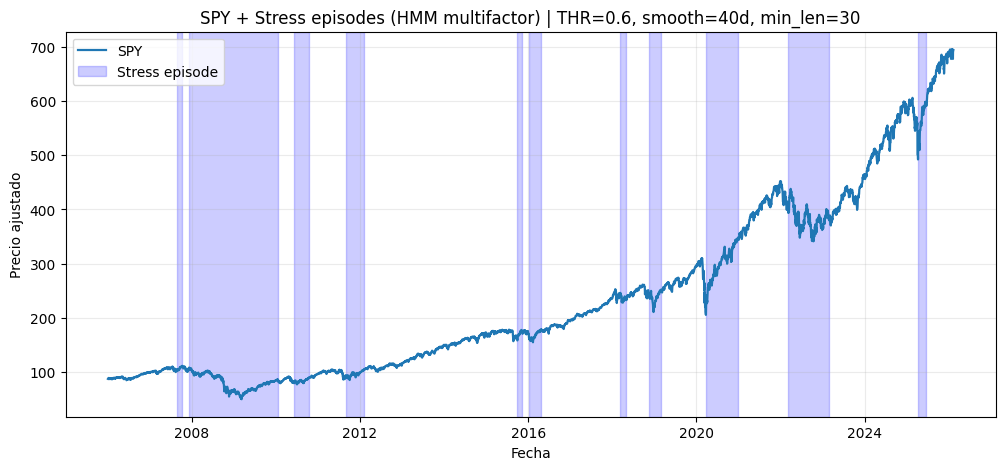

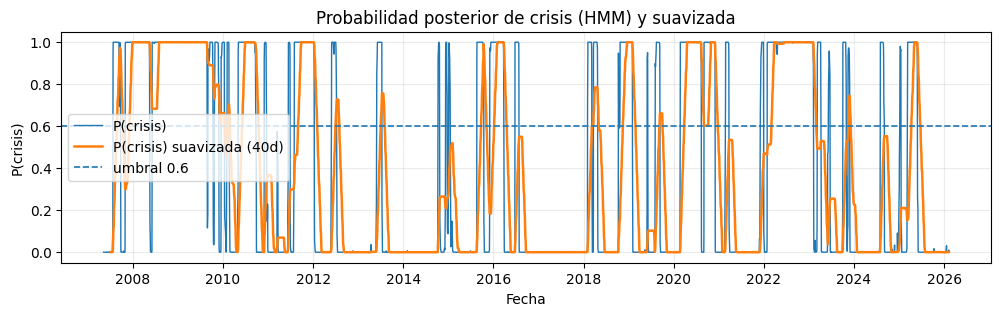

In [54]:
spy_plot = px["SPY"] #.reindex(feat_clip.index).ffill()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_plot.index, spy_plot.values, linewidth=1.6, label="SPY")

for (a, b) in episodes:
    ax.axvspan(a, b, alpha=0.20, color="blue", label="Stress episode")

# leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

ax.set_title(f"SPY + Stress episodes (HMM multifactor) | THR={THR}, smooth={SMOOTH}d, min_len={MIN_LEN}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio ajustado")
ax.grid(True, alpha=0.25)
plt.show()

# Plot de probabilidad (diagnóstico)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p_crisis.index, p_crisis, linewidth=1.0, label="P(crisis)")
ax.plot(p_crisis_smooth.index, p_crisis_smooth, linewidth=1.8, label=f"P(crisis) suavizada ({SMOOTH}d)")
ax.axhline(THR, linestyle="--", linewidth=1.2, label=f"umbral {THR}")
ax.set_title("Probabilidad posterior de crisis (HMM) y suavizada")
ax.set_xlabel("Fecha")
ax.set_ylabel("P(crisis)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# Fase 2 — Anatomía del Riesgo 

En esta fase cuantificamos cómo cambian las distribuciones **individuales** de los retornos cuando el mercado pasa de *calma* a *crisis*.

Para cada activo calculamos, **condicional a cada estado** (Estado 0 = Calma, Estado 1 = Crisis):
- **Media** (retorno esperado diario)
- **Volatilidad** (desviación típica diaria)
- **Skewness** (asimetría)
- **Kurtosis (exceso)** (colas: >0 indica colas más pesadas que normal)

Además, respondemos:
1) ¿Cuánto aumenta la volatilidad de **HYG** al pasar de Estado 0 a Estado 1?  
2) ¿Sigue siendo **GLD** un activo refugio? (lo evaluamos por su media/vol en crisis y, como extra, su correlación con SPY en crisis).


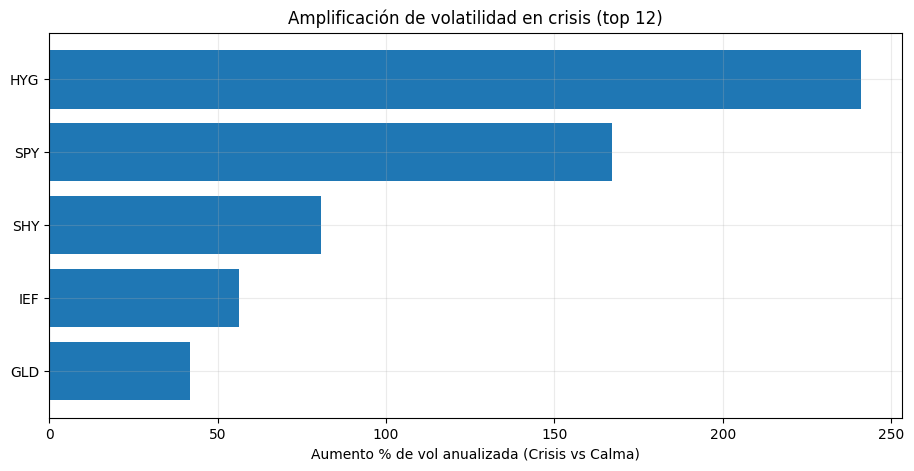

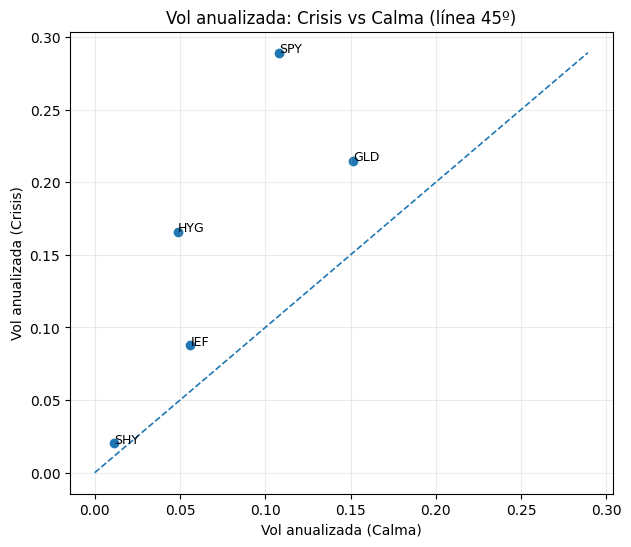

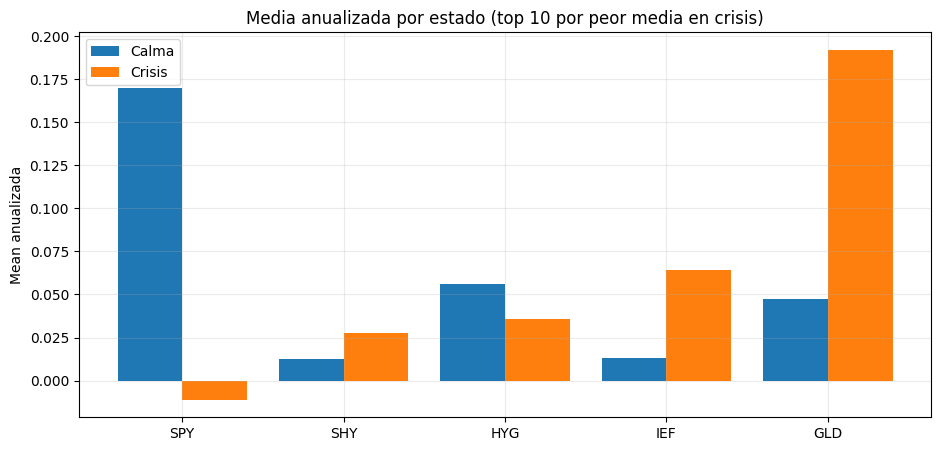

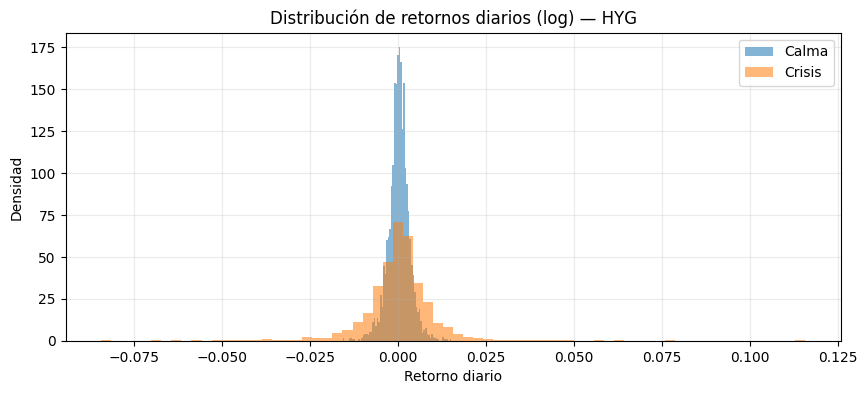

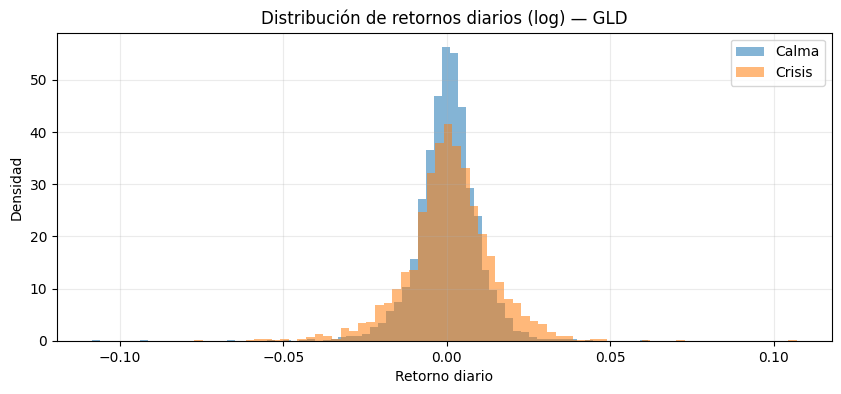

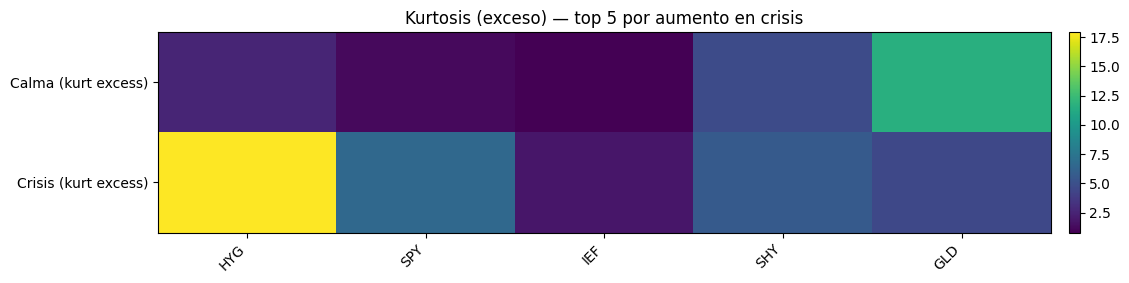

================= RESPUESTAS FASE 2 =================
(HYG) Vol anualizada Calma:  0.0486
(HYG) Vol anualizada Crisis: 0.1659
(HYG) Aumento (%):           241.09%  | Ratio: 3.411
(GLD) Mean anualizada Calma:  0.0471
(GLD) Mean anualizada Crisis: 0.1921  | Δ: 0.1450
(GLD) Vol anualizada Calma:   0.1515
(GLD) Vol anualizada Crisis:  0.2147  | Ratio: 1.417
(GLD vs SPY) Corr Calma: 0.074 | Corr Crisis: 0.041


In [55]:
# -----------------------------
# Checks
# -----------------------------
if "states" not in globals() or "crisis_state" not in globals():
    raise ValueError("No encuentro `states` y/o `crisis_state`. Ejecuta primero la Fase 1 (HMM).")

# -----------------------------
# 1) Estado 0/1: 0=Calma, 1=Crisis
# -----------------------------
wallet_crisis_prediction = (crisis_prediction == int(crisis_state)).astype(int)
wallet_crisis_prediction.name = "state01"

# -----------------------------
# 2) Retornos del universo (log) sin dropna global
# -----------------------------
universe = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL","JNJ",
    "JPM","MSFT","NVDA","PG","XOM",
    "IEF","SHY","HYG","SPY"
]
universe = [t for t in universe if t in px.columns]

R = np.log(px[universe]).diff()  # SIN dropna global
common_idx = R.index.intersection(wallet_crisis_prediction.index)
R = R.loc[common_idx]
wallet_crisis_prediction = wallet_crisis_prediction.loc[common_idx]

# -----------------------------
# 3) Momentos condicionales por estado
# -----------------------------
def moments(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "N": df.count(),
        "mean_d": df.mean(),
        "vol_d": df.std(),
        "skew": df.skew(),
        "kurt_excess": df.kurt()   # exceso de kurtosis (Fisher)
    })
    out["mean_ann"] = out["mean_d"] * 252
    out["vol_ann"]  = out["vol_d"] * np.sqrt(252)
    return out

mom_calm   = moments(R[wallet_crisis_prediction == 0]).add_prefix("calm_")
mom_crisis = moments(R[wallet_crisis_prediction == 1]).add_prefix("crisis_")

tab = pd.concat([mom_calm, mom_crisis], axis=1)

tab["vol_ratio"] = tab["crisis_vol_ann"] / tab["calm_vol_ann"]
tab["vol_increase_%"] = (tab["vol_ratio"] - 1.0) * 100
tab["mean_diff_ann"] = tab["crisis_mean_ann"] - tab["calm_mean_ann"]
tab["kurt_diff"] = tab["crisis_kurt_excess"] - tab["calm_kurt_excess"]
tab["skew_diff"] = tab["crisis_skew"] - tab["calm_skew"]

# Si algún activo tiene pocos datos en un estado, mejor filtrarlo un poco
MIN_N = 400
mask = (tab["calm_N"] >= MIN_N) & (tab["crisis_N"] >= MIN_N)
tab_f = tab[mask].copy()

# -----------------------------
# 4) VISUALES
# -----------------------------
# (A) Top "amplificación" de volatilidad
topN = 12
rank = tab_f.sort_values("vol_increase_%", ascending=False).head(topN)

fig, ax = plt.subplots(figsize=(11, 5))
ax.barh(rank.index[::-1], rank["vol_increase_%"][::-1])
ax.set_title(f"Amplificación de volatilidad en crisis (top {topN})")
ax.set_xlabel("Aumento % de vol anualizada (Crisis vs Calma)")
ax.grid(True, alpha=0.25)
plt.show()

# (B) Scatter: vol crisis vs vol calma (línea 45º)
fig, ax = plt.subplots(figsize=(7, 6))
x = tab_f["calm_vol_ann"].values
y = tab_f["crisis_vol_ann"].values
ax.scatter(x, y)

mx = np.nanmax([x.max(), y.max()])
ax.plot([0, mx], [0, mx], linestyle="--", linewidth=1.2)  # línea 45º

# Etiquetar solo algunos (los más relevantes) para no saturar
labels = tab_f.index.tolist()
for t in labels:
    ax.annotate(t, (tab_f.loc[t, "calm_vol_ann"], tab_f.loc[t, "crisis_vol_ann"]), fontsize=9)

ax.set_title("Vol anualizada: Crisis vs Calma (línea 45º)")
ax.set_xlabel("Vol anualizada (Calma)")
ax.set_ylabel("Vol anualizada (Crisis)")
ax.grid(True, alpha=0.25)
plt.show()

# (C) Mean anualizada: comparación Calma vs Crisis (top 10 por peor media en crisis)
topM = 10
rank_mean = tab_f.sort_values("crisis_mean_ann").head(topM)  # <- aquí definimos rank_mean

fig, ax = plt.subplots(figsize=(11, 5))
idx = np.arange(len(rank_mean))
ax.bar(idx - 0.2, rank_mean["calm_mean_ann"].values, width=0.4, label="Calma")
ax.bar(idx + 0.2, rank_mean["crisis_mean_ann"].values, width=0.4, label="Crisis")
ax.set_xticks(idx)
ax.set_xticklabels(rank_mean.index, rotation=0)
ax.set_title(f"Media anualizada por estado (top {topM} por peor media en crisis)")
ax.set_ylabel("Mean anualizada")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# (D) Distribuciones (hist) para HYG y GLD por estado
def plot_hist_asset(ticker, bins=70):
    if ticker not in R.columns:
        print(f"[WARN] {ticker} no está en retornos.")
        return
    r0 = R.loc[wallet_crisis_prediction == 0, ticker].dropna()
    r1 = R.loc[wallet_crisis_prediction == 1, ticker].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(r0.values, bins=bins, density=True, alpha=0.55, label="Calma")
    ax.hist(r1.values, bins=bins, density=True, alpha=0.55, label="Crisis")
    ax.set_title(f"Distribución de retornos diarios (log) — {ticker}")
    ax.set_xlabel("Retorno diario")
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

plot_hist_asset("HYG")
plot_hist_asset("GLD")

# (E) “Mapa rápido” de colas/asimetría (top por kurtosis diff)
topK = min(15, len(tab_f))
rank_k = tab_f.sort_values("kurt_diff", ascending=False).head(topK)
vals = np.vstack([rank_k["calm_kurt_excess"].values, rank_k["crisis_kurt_excess"].values])

fig, ax = plt.subplots(figsize=(12, 2.6))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks([0,1])
ax.set_yticklabels(["Calma (kurt excess)", "Crisis (kurt excess)"])
ax.set_xticks(np.arange(topK))
ax.set_xticklabels(rank_k.index, rotation=45, ha="right")
ax.set_title(f"Kurtosis (exceso) — top {topK} por aumento en crisis")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.show()

# -----------------------------
# 5) Respuestas directas a las preguntas (HYG y GLD)
# -----------------------------
print("================= RESPUESTAS FASE 2 =================")

if "HYG" in tab.index:
    hyg = tab.loc["HYG"]
    print(f"(HYG) Vol anualizada Calma:  {hyg['calm_vol_ann']:.4f}")
    print(f"(HYG) Vol anualizada Crisis: {hyg['crisis_vol_ann']:.4f}")
    print(f"(HYG) Aumento (%):           {hyg['vol_increase_%']:.2f}%  | Ratio: {hyg['vol_ratio']:.3f}")
else:
    print("(HYG) No disponible en el dataset.")

if "GLD" in tab.index:
    gld = tab.loc["GLD"]
    print(f"(GLD) Mean anualizada Calma:  {gld['calm_mean_ann']:.4f}")
    print(f"(GLD) Mean anualizada Crisis: {gld['crisis_mean_ann']:.4f}  | Δ: {gld['mean_diff_ann']:.4f}")
    print(f"(GLD) Vol anualizada Calma:   {gld['calm_vol_ann']:.4f}")
    print(f"(GLD) Vol anualizada Crisis:  {gld['crisis_vol_ann']:.4f}  | Ratio: {gld['vol_ratio']:.3f}")

    # Extra: correlación GLD vs SPY condicional
    if "SPY" in R.columns:
        corr_calm = R.loc[wallet_crisis_prediction == 0, "GLD"].corr(R.loc[wallet_crisis_prediction == 0, "SPY"])
        corr_cris = R.loc[wallet_crisis_prediction == 1, "GLD"].corr(R.loc[wallet_crisis_prediction == 1, "SPY"])
        print(f"(GLD vs SPY) Corr Calma: {corr_calm:.3f} | Corr Crisis: {corr_cris:.3f}")
else:
    print("(GLD) No disponible en el dataset.")


## Fase 3 — Cuando la diversificación falla (cópulas)

### 1) Correlación Pearson por régimen
- Se calcula la matriz de correlación de retornos diarios **condicional a cada estado** (HMM).
- Evidencia típica: en *Crisis* aumenta la **correlación media off-diagonal** y la distribución de correlaciones se desplaza hacia valores altos.
- En el subuniverso de **risk assets** (equity + HY) el efecto suele ser más marcado que cuando mezclamos defensivos (bonos/oro).

### 2) t-cópula multivariante (dependencia en colas)
- Se ajusta una **t-cópula** en cada régimen usando pseudo-observaciones (ranks → U(0,1)).
- La t-cópula introduce dependencia en colas mediante los **grados de libertad**:
  - **Alto** ⇒ comportamiento cercano a Gaussiana (colas “finas”) → típico de *Calma*.
  - **Bajo** ⇒ colas gruesas y más probabilidad de extremos conjuntos → típico de *Crisis*.

### 3) Extra: Clayton (bivariada) para cola izquierda
- Se usa **Clayton** como contraste específico de *riesgo*, ya que modela **dependencia de cola inferior**.
- A partir de Kendall  se obtiene theta y la métrica lambda (probabilidad de caídas conjuntas).
- En crisis se observan **pares con lambda significativamente mayor**, apoyando que la diversificación falla precisamente en la cola.

In [56]:
# Subconjuntos para interpretacion
equities = ["AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GME","GOOGL","JNJ","JPM","MSFT","NVDA","PG","XOM"]
def_assets  = ["IEF","SHY","GLD"]
risk_assets = ["HYG"] + equities

wallet = risk_assets + def_assets

print("Activos totales:", len(wallet), "| Risk assets:", len(risk_assets), "| Defensivos:", len(def_assets))

Activos totales: 18 | Risk assets: 15 | Defensivos: 3


In [57]:
#Descarga de todos los tickers
wallet_px = yf.download(
    wallet,
    start=FROM,
    end=TO,
    auto_adjust=True,
    progress=False)["Close"]

In [63]:
# Retornos log (sin dropna global)
wallet_returns = np.log(wallet_px).diff()

print("Dias con datos en HMM:", len(crisis_prediction))
print("Dias con datos en la cartera:", len(wallet_returns))

# Cogemos los dias comunes entre HMM y los precios de la cartera
common_idx = wallet_returns.index.intersection(crisis_prediction.index)
wallet_crisis_prediction = crisis_prediction.loc[common_idx]
wallet_returns = wallet_returns.loc[common_idx]

print("Dias en comun:", len(wallet_returns), "| Dias de crisis:", 100 * wallet_crisis_prediction.mean(), "%")

Dias con datos en HMM: 4719
Dias con datos en la cartera: 5057
Dias en comun: 4719 | Dias de crisis: 38.52511125238398 %


In [68]:
def vec_offdiag(df: pd.DataFrame):
    values = df.values
    mask = ~np.eye(values.shape[0], dtype=bool)
    return values[mask]

def offdiag_mean(df: pd.DataFrame) -> float:
    return np.nanmean(vec_offdiag(df))

In [90]:
# -----------------------------
# 1) Correlación Pearson por régimen
# -----------------------------

# Minimo numero de dias que tenemos que tener un ticker en la cartera para considerarlo
TICKER_MIN_SAMPLES = 400

calm_state = 0 if crisis_state else 1

wallet_calm_returns = wallet_returns.loc[wallet_crisis_prediction == calm_state]
wallet_crisis_returns = wallet_returns.loc[wallet_crisis_prediction == crisis_state]

# Nos quedamos los tickers que tengan suficientes datos en ambos regimenes
tickers_to_keep = []
for c in wallet_returns.columns:
    n0 = wallet_calm_returns[c].count()
    n1 = wallet_crisis_returns[c].count()
    if (n0 >= TICKER_MIN_SAMPLES) and (n1 >= TICKER_MIN_SAMPLES):
        tickers_to_keep.append(c)


wallet_calm_returns = wallet_calm_returns[tickers_to_keep]
wallet_crisis_returns = wallet_crisis_returns[tickers_to_keep]

wallet_calm_correlation = wallet_calm_returns.corr(method="pearson")
wallet_crisis_correlation = wallet_crisis_returns.corr(method="pearson")

print(f"Activos con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(tickers_to_keep)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(wallet_calm_correlation))
print("Corr media off-diag (Crisis): ", offdiag_mean(wallet_crisis_correlation))


Activos con N >= 400 en ambos regimenes: 18
Corr media off-diag (Calma):   0.1395734751485696
Corr media off-diag (Crisis):  0.285311406790745


In [92]:
risk_tickers = [t for t in risk_assets if t in tickers_to_keep]
risk_tickers_calm_returns = wallet_calm_returns[risk_tickers].corr()
risk_tickers_crisis_returns = wallet_calm_returns[risk_tickers].corr()
print(f"Risk Assets con N >= {TICKER_MIN_SAMPLES} en ambos regimenes: {len(risk_tickers)}")
print("Corr media off-diag (Calma):  ", offdiag_mean(risk_tickers_calm_returns))
print("Corr media off-diag (Crisis): ", offdiag_mean(risk_tickers_crisis_returns))

Risk Assets con N >= 400 en ambos regimenes: 15
Corr media off-diag (Calma):   0.20999218730413707
Corr media off-diag (Crisis):  0.20999218730413707


In [70]:
def plot_heatmap_corr(C: pd.DataFrame, title: str, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(C.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(C.shape[1]))
    ax.set_yticks(range(C.shape[0]))
    ax.set_xticklabels(C.columns, rotation=90)
    ax.set_yticklabels(C.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    ax.grid(False)
    plt.show()

### Gráficos

In [83]:
V_MIN = -1
V_MAX = 1
GROUP_RANGE = 0.03

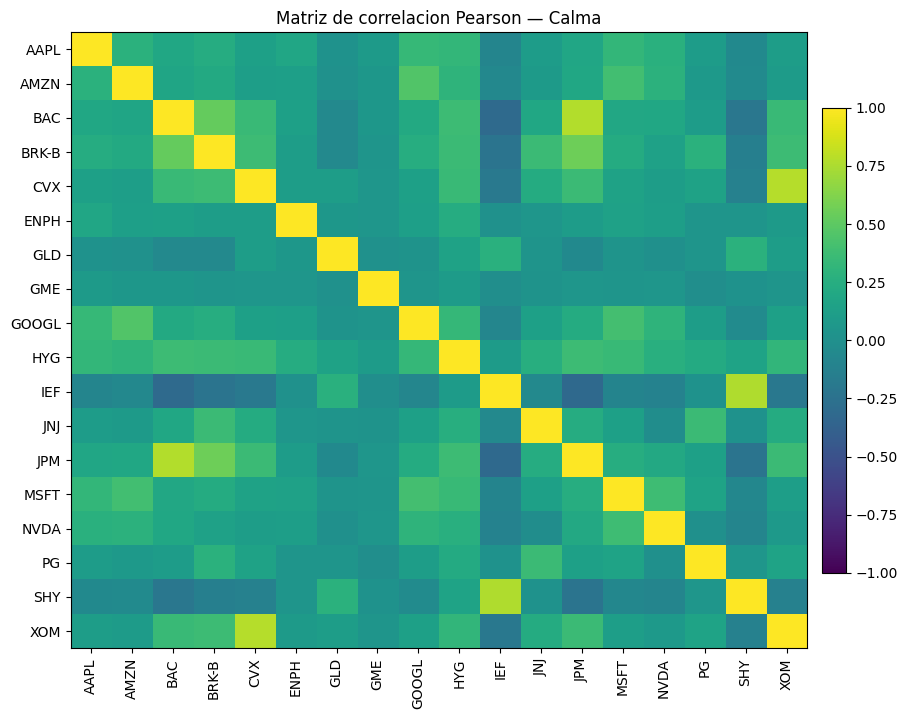

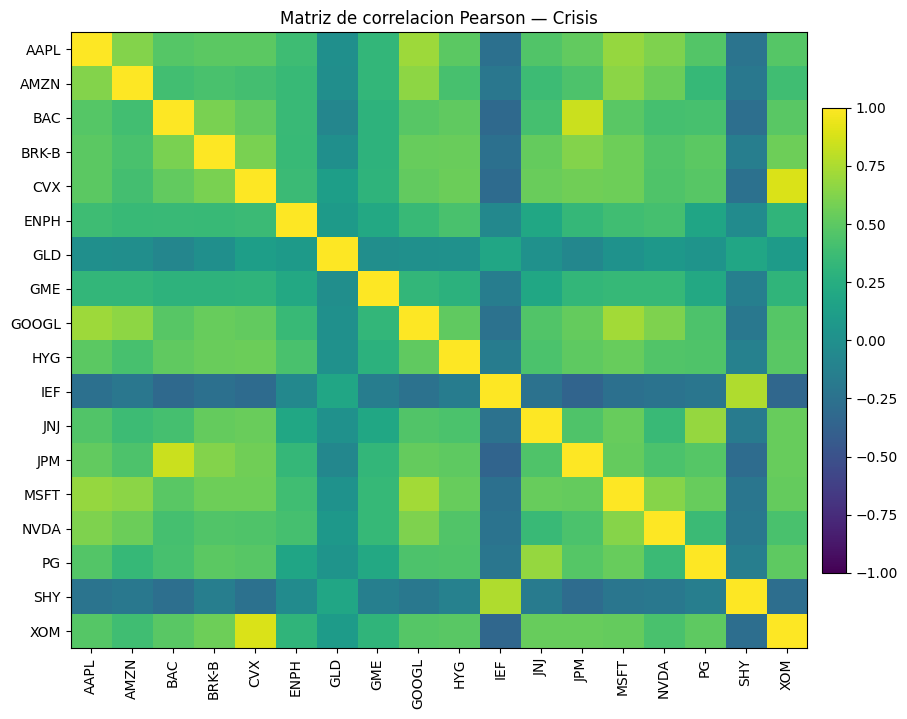

In [71]:
plot_heatmap_corr(wallet_calm_correlation, "Matriz de correlacion Pearson — Calma", vmin=V_MIN, vmax=V_MAX)
plot_heatmap_corr(wallet_crisis_correlation, "Matriz de correlacion Pearson — Crisis", vmin=V_MIN, vmax=V_MAX)

#### Visualización de las correlaciones en grupos de bins

Visualizamos los grupos de las correlaciones de ambas carteras, en g

66


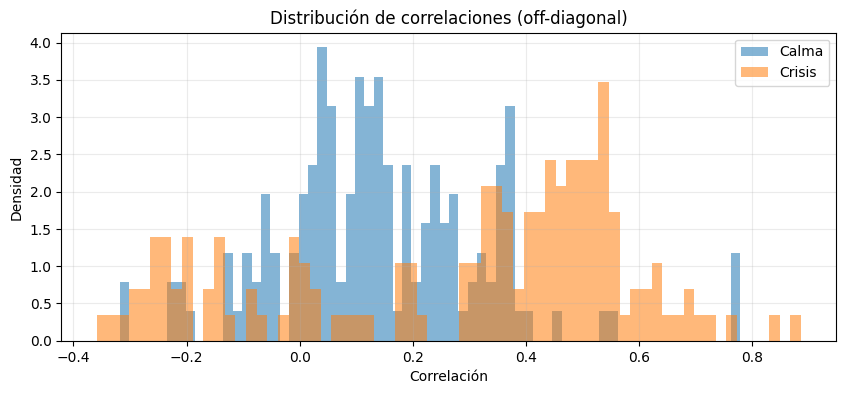

In [84]:
wallet_calm_correlation_values = vec_offdiag(wallet_calm_correlation)
wallet_crisis_correlation_values = vec_offdiag(wallet_crisis_correlation)

bins = int((V_MAX - V_MIN) / GROUP_RANGE)
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(wallet_calm_correlation_values, bins=bins, density=True, alpha=0.55, label="Calma")
ax.hist(wallet_crisis_correlation_values, bins=bins, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

In [ ]:
def pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observaciones U(0,1) via ranks: u = rank/(n+1)."""
    X = df.values
    n, k = X.shape
    U = np.empty_like(X, dtype=float)
    for j in range(k):
        col = X[:, j]
        # rankdata maneja empates
        r = st.rankdata(col, method="average")
        U[:, j] = r / (n + 1.0)
    return U

def nearest_psd(A: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Proyecta a PSD por clipping de eigenvalores."""
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, eps)
    B = (V * w) @ V.T
    # normalizar a correlación (diag = 1)
    d = np.sqrt(np.diag(B))
    B = B / np.outer(d, d)
    return 0.5 * (B + B.T)



def t_tail_dependence(rho: float, nu: float) -> float:
    """
    Coeficiente de dependencia en cola (simétrica) para t-copula:
    λ = 2 * t_{nu+1}(-sqrt((nu+1)*(1-rho)/(1+rho)))
    """
    if rho >= 0.999999:
        return 1.0
    if rho <= -0.999999:
        return 0.0
    a = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * st.t.cdf(a, df=nu + 1.0)


### Cópulas

In [85]:
def fit_t_copula_ifm(df: pd.DataFrame, nu_grid, shrink=0.02):

    X = df.dropna(axis=0, how="any")

    U = pseudo_obs(X)
    k = U.shape[1]
    ll_list = []

    for nu in nu_grid:
        # Transformación t
        Z = st.t.ppf(U, df=nu)
        # Correlación en el espacio latente
        Rho = np.corrcoef(Z, rowvar=False)
        # Shrinkage leve para estabilidad
        Rho = (1 - shrink) * Rho + shrink * np.eye(k)
        Rho = nearest_psd(Rho)

        # log c(u) = log f_tk(Z;nu,Rho) - sum log f_t1(Z_i;nu)
        mvt = st.multivariate_t(loc=np.zeros(k), shape=Rho, df=nu)
        ll_m = mvt.logpdf(Z).sum()
        ll_u = st.t.logpdf(Z, df=nu).sum()
        ll = ll_m - ll_u
        ll_list.append((nu, ll, len(X), k))

    ll_df = pd.DataFrame(ll_list, columns=["nu", "loglik", "N", "K"]).sort_values("loglik", ascending=False)
    nu_hat = int(ll_df.iloc[0]["nu"])

    # Re-estimar Rho con nu_hat
    Z = st.t.ppf(U, df=nu_hat)
    Rho = np.corrcoef(Z, rowvar=False)
    Rho = (1 - shrink) * Rho + shrink * np.eye(k)
    Rho = nearest_psd(Rho)

    return nu_hat, Rho, ll_df, X.columns

In [86]:
print("--- Ajuste t-copula (multivariante) ---")
print("Activos usados para copula:", tickers_to_keep)

wallet_calm_returns = wallet_calm_returns.dropna(how="any")
wallet_crisis_returns = wallet_crisis_returns.dropna(how="any")

nu_grid = [1,2,3,4,5,6,7,8,9,10,12,15,20,30,50,80, 100]
nu0, Rho0, ll0, cols0 = fit_t_copula_ifm(wallet_calm_returns, nu_grid=nu_grid, shrink=0.02)
nu1, Rho1, ll1, cols1 = fit_t_copula_ifm(wallet_crisis_returns, nu_grid=nu_grid, shrink=0.02)

# Un valor alto indica colas mas grandes (mas separados). Un valor pequenho indica que los activos estan mas correlacionados
print(f"t-copula Calma:  nu_hat = {nu0}")
print(f"t-copula Crisis: nu_hat = {nu1}")

--- Ajuste t-copula (multivariante) ---
Activos usados para copula: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 'HYG', 'IEF', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'SHY', 'XOM']
t-copula Calma:  nu_hat = 15
t-copula Crisis: nu_hat = 10


,nu,loglik,N,K
11,15,8828.5,2476,18
12,20,8828.4,2476,18
10,12,8795.2,2476,18
13,30,8782.7,2476,18
9,10,8734.5,2476,18
14,50,8696.1,2476,18
8,9,8680.5,2476,18
15,80,8616.2,2476,18


,nu,loglik,N,K
9,10,7354.2,1008,18
10,12,7351.0,1008,18
8,9,7350.6,1008,18
7,8,7340.3,1008,18
11,15,7335.8,1008,18
6,7,7318.4,1008,18
12,20,7305.1,1008,18
5,6,7274.8,1008,18


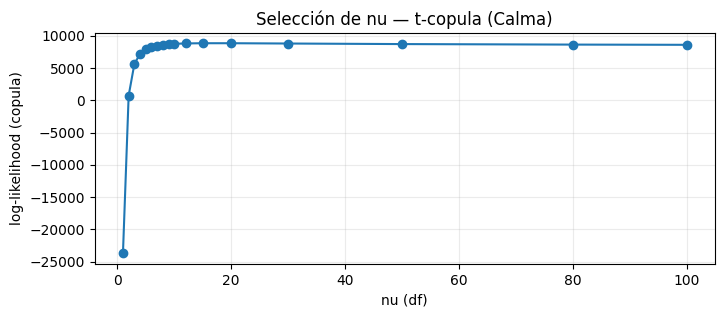

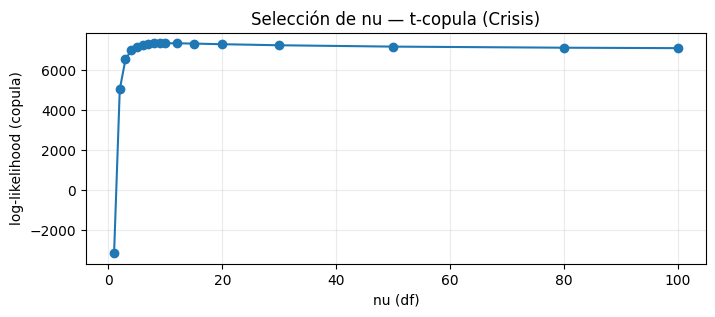

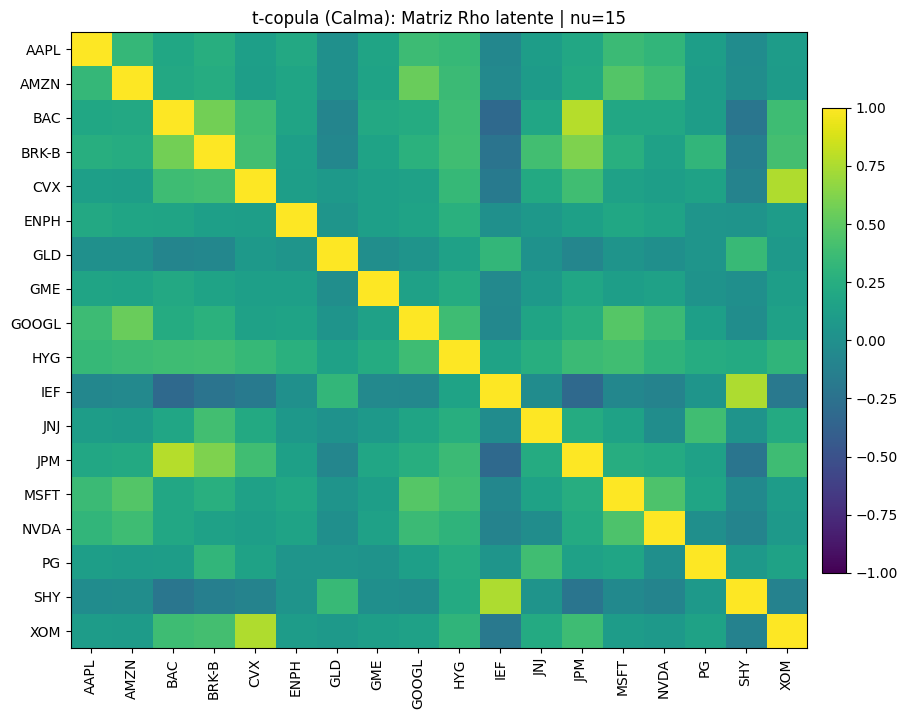

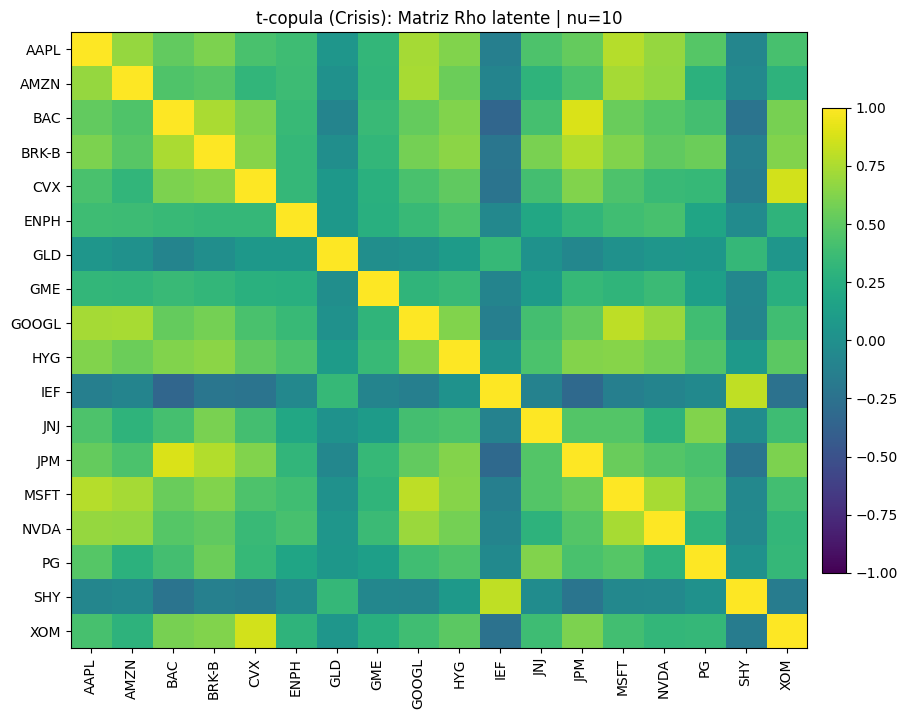

,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.780,0.179
74,CVX,XOM,0.765,0.164
130,IEF,SHY,0.756,0.156
56,BRK-B,JPM,0.610,0.066
33,BAC,BRK-B,0.574,0.054
23,AMZN,GOOGL,0.540,0.044
112,GOOGL,MSFT,0.473,0.029
28,AMZN,MSFT,0.467,0.028
143,MSFT,NVDA,0.442,0.024
61,BRK-B,XOM,0.401,0.019


,asset_i,asset_j,rho_latent,lambda_tail
42,BAC,JPM,0.887,0.435
74,CVX,XOM,0.861,0.385
130,IEF,SHY,0.809,0.304
112,GOOGL,MSFT,0.804,0.298
12,AAPL,MSFT,0.779,0.267
56,BRK-B,JPM,0.772,0.259
33,BAC,BRK-B,0.748,0.234
23,AMZN,GOOGL,0.735,0.222
143,MSFT,NVDA,0.735,0.221
28,AMZN,MSFT,0.734,0.220


Resumen tail dependence (t-copula):
Media λ (Calma):  0.009628398880968798
Media λ (Crisis): 0.06797300456482919


In [93]:

# Tabla log-likelihood (top 8)
display(ll0.head(8).style.format({"loglik":"{:.1f}"}).set_caption("t-copula — Calma (mejores nu por log-likelihood)"))
display(ll1.head(8).style.format({"loglik":"{:.1f}"}).set_caption("t-copula — Crisis (mejores nu por log-likelihood)"))

# Plot ll vs nu
def plot_ll(ll_df, title):
    tmp = ll_df.sort_values("nu")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(tmp["nu"], tmp["loglik"], marker="o")
    ax.set_title(title)
    ax.set_xlabel("nu (df)")
    ax.set_ylabel("log-likelihood (copula)")
    ax.grid(True, alpha=0.25)
    plt.show()

plot_ll(ll0, "Selección de nu — t-copula (Calma)")
plot_ll(ll1, "Selección de nu — t-copula (Crisis)")

# Mostrar matrices de correlación latente (copula) como heatmap
C_t0 = pd.DataFrame(Rho0, index=cols0, columns=cols0)
C_t1 = pd.DataFrame(Rho1, index=cols1, columns=cols1)

plot_heatmap_corr(C_t0, f"t-copula (Calma): Matriz Rho latente | nu={nu0}", vmin=-1, vmax=1)
plot_heatmap_corr(C_t1, f"t-copula (Crisis): Matriz Rho latente | nu={nu1}", vmin=-1, vmax=1)

# Tail dependence (t-copula) por pares: resumen
def pair_table_taildep(Rho, cols, nu, top=12):
    cols = list(cols)
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            rho = float(Rho[i, j])
            lam = t_tail_dependence(rho, nu)
            out.append((cols[i], cols[j], rho, lam))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","rho_latent","lambda_tail"])
    df = df.sort_values("lambda_tail", ascending=False)
    return df.head(top), df

top0, all0 = pair_table_taildep(Rho0, cols0, nu0, top=12)
top1, all1 = pair_table_taildep(Rho1, cols1, nu1, top=12)

display(top0.style.format({"rho_latent":"{:.3f}","lambda_tail":"{:.3f}"}).set_caption("t-copula — Top tail dependence (Calma)"))
display(top1.style.format({"rho_latent":"{:.3f}","lambda_tail":"{:.3f}"}).set_caption("t-copula — Top tail dependence (Crisis)"))

print("Resumen tail dependence (t-copula):")
print("Media λ (Calma): ", all0["lambda_tail"].mean())
print("Media λ (Crisis):", all1["lambda_tail"].mean())

In [ ]:

def clayton_theta_from_tau(tau: float) -> float:
    """Clayton: theta = 2*tau/(1-tau) para tau in (0,1)."""
    if tau <= 0 or tau >= 0.999999:
        return np.nan
    return 2.0 * tau / (1.0 - tau)

def clayton_lower_tail(theta: float) -> float:
    """Clayton: lambda_L = 2^(-1/theta)."""
    if not np.isfinite(theta) or theta <= 0:
        return np.nan
    return 2.0 ** (-1.0 / theta)

Obs. totales alineadas: 4719 | % Crisis: 38.52511125238398 %
--- Pearson (activos con N>=MIN_N en ambos regímenes) ---
K = 18 | N_calm(min col count) = 2476 | N_crisis(min col count) = 1008
Corr media off-diag (Calma):   0.1395734751485696
Corr media off-diag (Crisis):  0.285311406790745


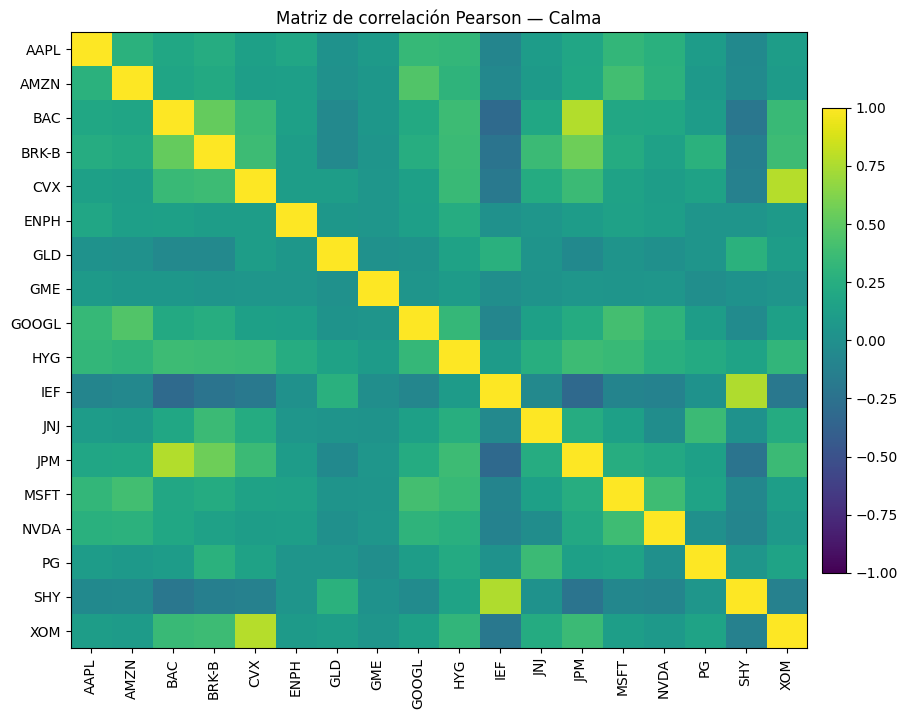

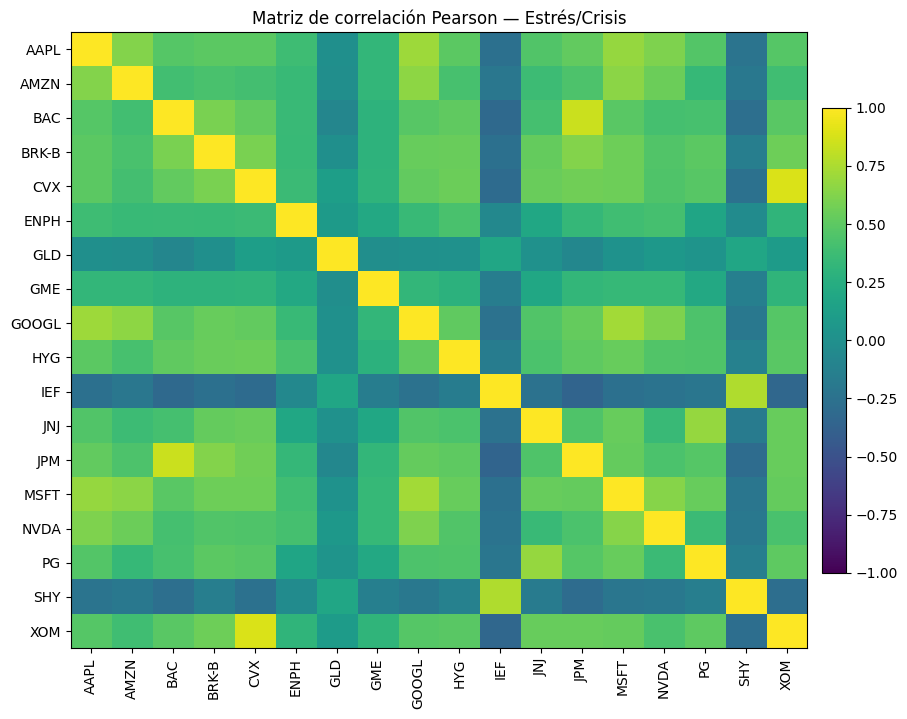

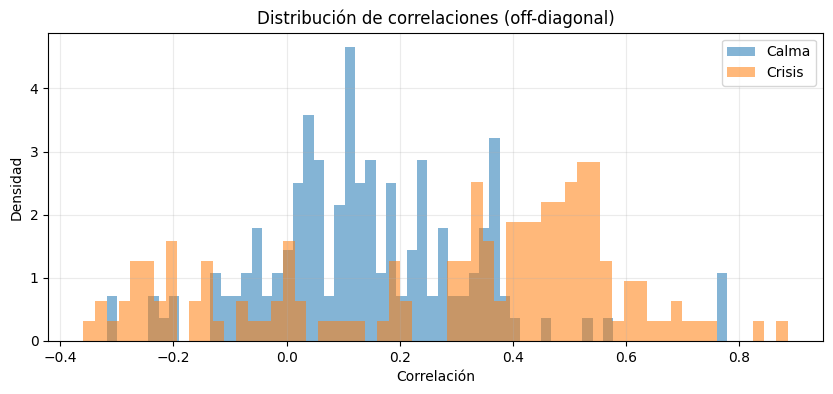

--- Solo Risk Assets (equities + HYG) ---
K_risk = 15
Corr media off-diag (Calma):   0.20999218730413707
Corr media off-diag (Crisis):  0.46434926573523444
--- Ajuste t-cópula (multivariante) ---
Activos usados para copula: ['HYG', 'AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GME', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM']
N completo Calma: 2476 | N completo Crisis: 1008 | K: 15
[RESULT] t-copula Calma:  nu_hat = 15
[RESULT] t-copula Crisis: nu_hat = 10


,nu,loglik,N,K
8,15,6998.1,2476,15
9,20,6989.8,2476,15
7,12,6978.0,2476,15
10,30,6943.2,2476,15
6,10,6934.8,2476,15
11,50,6864.6,2476,15
5,8,6832.5,2476,15
12,80,6795.3,2476,15


,nu,loglik,N,K
6,10,6495.8,1008,15
5,8,6489.5,1008,15
7,12,6489.4,1008,15
4,7,6474.8,1008,15
8,15,6472.7,1008,15
3,6,6443.5,1008,15
9,20,6442.7,1008,15
10,30,6394.1,1008,15


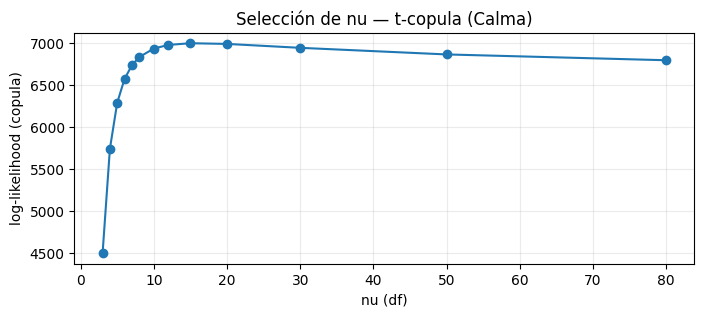

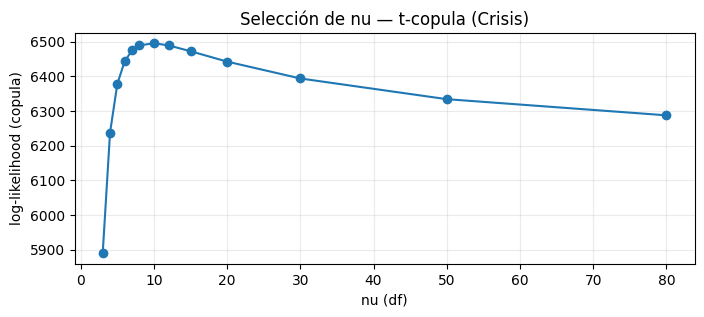

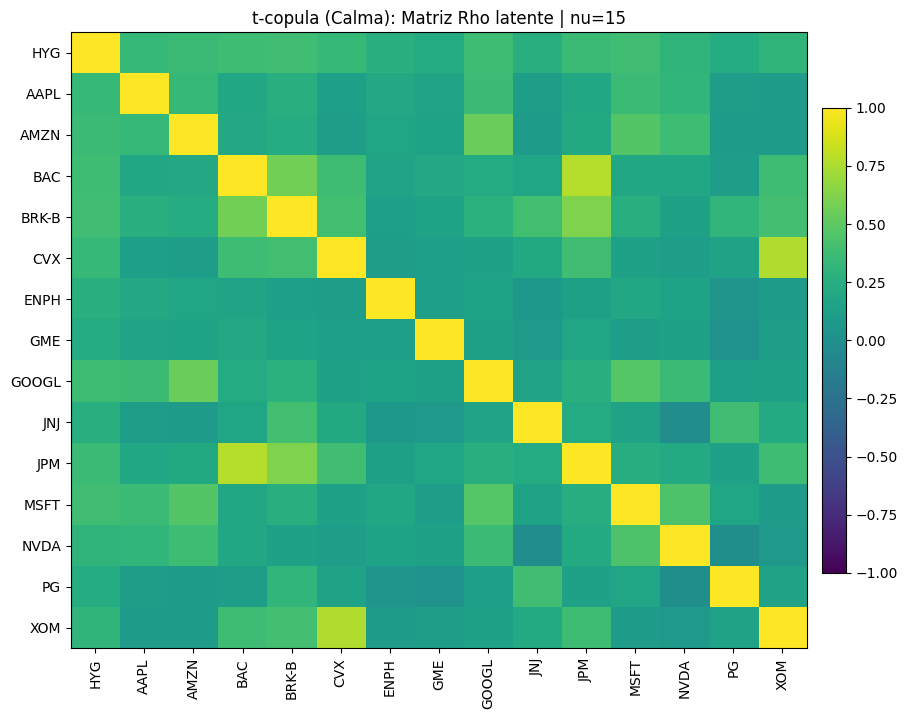

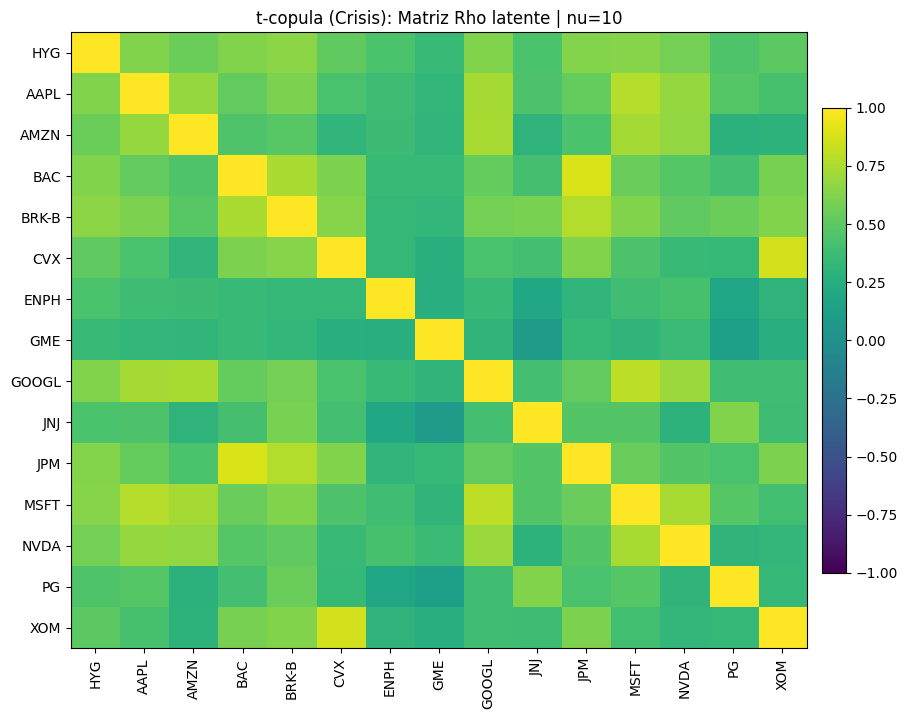

,asset_i,asset_j,rho_latent,lambda_tail
45,BAC,JPM,0.780,0.179
68,CVX,XOM,0.765,0.164
55,BRK-B,JPM,0.610,0.066
39,BAC,BRK-B,0.574,0.054
32,AMZN,GOOGL,0.540,0.044
86,GOOGL,MSFT,0.473,0.029
35,AMZN,MSFT,0.467,0.028
99,MSFT,NVDA,0.442,0.024
59,BRK-B,XOM,0.401,0.019
54,BRK-B,JNJ,0.397,0.018


,asset_i,asset_j,rho_latent,lambda_tail
45,BAC,JPM,0.887,0.435
68,CVX,XOM,0.861,0.385
86,GOOGL,MSFT,0.804,0.298
23,AAPL,MSFT,0.779,0.267
55,BRK-B,JPM,0.772,0.259
39,BAC,BRK-B,0.748,0.234
32,AMZN,GOOGL,0.735,0.222
99,MSFT,NVDA,0.735,0.221
35,AMZN,MSFT,0.734,0.220
20,AAPL,GOOGL,0.730,0.216


Resumen tail dependence (t-copula):
Media λ (Calma):  0.011864359456129903
Media λ (Crisis): 0.09317454061262369


,asset_i,asset_j,kendall_tau,theta_clayton,lambda_L
45,BAC,JPM,0.594,2.928,0.789
68,CVX,XOM,0.588,2.855,0.784
55,BRK-B,JPM,0.426,1.482,0.626
39,BAC,BRK-B,0.389,1.272,0.580
32,AMZN,GOOGL,0.385,1.254,0.575
86,GOOGL,MSFT,0.338,1.023,0.508
35,AMZN,MSFT,0.321,0.947,0.481
99,MSFT,NVDA,0.298,0.850,0.442
93,JNJ,PG,0.293,0.827,0.432
54,BRK-B,JNJ,0.279,0.775,0.409


,asset_i,asset_j,kendall_tau,theta_clayton,lambda_L
68,CVX,XOM,0.714,4.988,0.870
45,BAC,JPM,0.697,4.598,0.860
86,GOOGL,MSFT,0.541,2.361,0.746
32,AMZN,GOOGL,0.526,2.222,0.732
20,AAPL,GOOGL,0.519,2.156,0.725
23,AAPL,MSFT,0.511,2.092,0.718
35,AMZN,MSFT,0.505,2.040,0.712
14,AAPL,AMZN,0.484,1.875,0.691
55,BRK-B,JPM,0.484,1.874,0.691
39,BAC,BRK-B,0.472,1.791,0.679


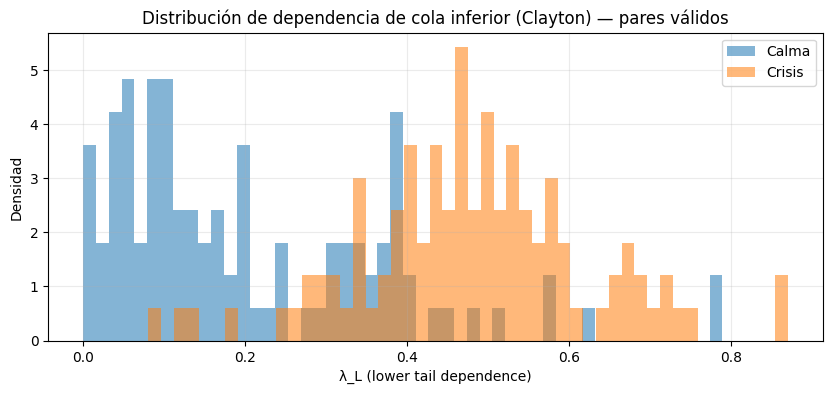

Resumen λ_L (Clayton):
Media λ_L Calma:  0.20387208778796526
Media λ_L Crisis: 0.47920197510199086


In [58]:

# -----------------------------
# 3) EXTRA — Clayton bivariada (cola inferior) por régimen
# -----------------------------
# Clayton es especialmente útil para “caídas conjuntas” (lower tail dependence).
# Lo hacemos bivariado por pares y comparamos Calma vs Crisis.
pairs_assets = focus_assets  # mismo conjunto que usaste arriba
X0p = R0[pairs_assets]
X1p = R1[pairs_assets]

# Kendall tau por régimen
Tau0 = X0p.corr(method="kendall")
Tau1 = X1p.corr(method="kendall")

def clayton_table(Tau_mat: pd.DataFrame, top=15, title=""):
    cols = Tau_mat.columns
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau_mat.iloc[i, j]
            theta = clayton_theta_from_tau(tau)
            lamL  = clayton_lower_tail(theta)
            out.append((cols[i], cols[j], float(tau), float(theta) if np.isfinite(theta) else np.nan, float(lamL) if np.isfinite(lamL) else np.nan))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","kendall_tau","theta_clayton","lambda_L"])
    df = df.dropna(subset=["lambda_L"]).sort_values("lambda_L", ascending=False).head(top)
    return df

cl0 = clayton_table(Tau0, top=15)
cl1 = clayton_table(Tau1, top=15)

display(cl0.style.format({"kendall_tau":"{:.3f}","theta_clayton":"{:.3f}","lambda_L":"{:.3f}"}).set_caption("Clayton (Calma) — Top cola inferior"))
display(cl1.style.format({"kendall_tau":"{:.3f}","theta_clayton":"{:.3f}","lambda_L":"{:.3f}"}).set_caption("Clayton (Crisis) — Top cola inferior"))

# Comparativa simple: distribución de λ_L (Clayton) en calma vs crisis (para todos los pares válidos)
def all_lambdaL(Tau_mat):
    cols = Tau_mat.columns
    vals = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau_mat.iloc[i, j]
            th = clayton_theta_from_tau(tau)
            lamL = clayton_lower_tail(th)
            if np.isfinite(lamL):
                vals.append(lamL)
    return np.array(vals)

lam0 = all_lambdaL(Tau0)
lam1 = all_lambdaL(Tau1)

fig, ax = plt.subplots(figsize=(10,4))
ax.hist(lam0, bins=50, density=True, alpha=0.55, label="Calma")
ax.hist(lam1, bins=50, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de dependencia de cola inferior (Clayton) — pares válidos")
ax.set_xlabel("λ_L (lower tail dependence)")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

print("Resumen λ_L (Clayton):")
print("Media λ_L Calma: ", np.nanmean(lam0) if len(lam0)>0 else np.nan)
print("Media λ_L Crisis:", np.nanmean(lam1) if len(lam1)>0 else np.nan)